### ZEKİ TOPÇU, MVA, zekitopccu@gmail.com ###

SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels


from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip uninstall networkx
# !pip install networkx==2.8.8
#!unzip semi_supervised_learning.zip

#from zipfile import ZipFile
#file_name = "/content/semi_supervised_learning.zip"

#with ZipFile(file_name, 'r') as zip:
 # zip.extractall()
 # print('Done')

In [4]:
"""
Define parameters for HFS

"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = 0.99
params['c_u'] = 0.01

In [5]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    
    """
    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1
    
    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    
    """
    encoder = OneHotEncoder(handle_unknown='ignore')
    y = encoder.fit_transform(Y.reshape(-1,1)).toarray()
    
    # 0 is unlabeled so we delete it
    y = y[:, 1:] 
    
    l_idx = np.where(Y!=0)[0]
    u_idx = np.where(Y==0)[0]
    
    if not soft:    
        """
        Compute hard HFS.  
        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """        
        l_uu = L[:,u_idx][u_idx]
        l_ul = L[:,l_idx][u_idx]            
        f_l = y[l_idx]
        f_u = -1* np.linalg.pinv(l_uu) @ l_ul @ f_l         
        f = np.zeros((num_samples, num_classes))
        f[l_idx] = f_l
        f[u_idx] = f_u
 
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        c_l = params['c_l']
        c_u = params['c_u']        
        C = np.zeros(num_samples)
        C[l_idx] = c_l
        C[u_idx] = c_u       
        C = np.diag(C)        
        f = np.linalg.pinv(np.linalg.pinv(C) @ L + np.eye(num_samples)) @ y

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    
    labels = np.argmax(f, axis=1) + 1  
    
    return labels, f

In [6]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', 
                  PerClass=False, plot=True, print_accuracy= True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of "noisy" labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    per_class : bool
        If True, we select "l" labeled samples per class. Otherwise, we select "l" labeled samples in total.
    plot : bool
        If True, show plots
    print_accuracy : bool 
        If True, print the accuracy 
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class = PerClass)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    L = build_laplacian_regularized(X, 
                                    laplacian_regularization = params['laplacian_regularization'], 
                                    var = params['var'], 
                                    eps = params['eps'],
                                    k = params['k'],
                                    laplacian_normalization = params['laplacian_normalization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)
    accuracy = np.mean(labels == np.squeeze(Y))

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    
    if print_accuracy:
        print(f"Soft={soft}, Accuracy={accuracy}")
    
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

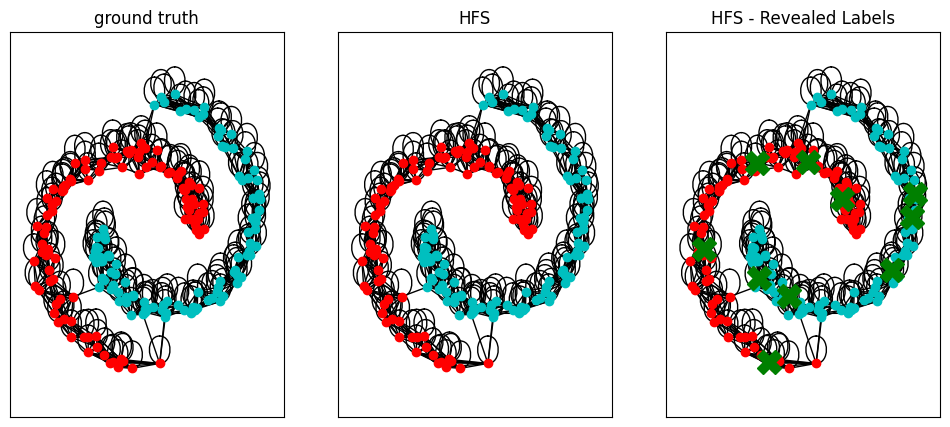

Soft=False, Accuracy=1.0


In [7]:
# Construct a connected graph 
params['k'] = 10
params['laplacian_normalization'] = 'unn'

# Apply HFS to two-moons dataset
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, 
                                                 dataset='data_2moons_hfs.mat', plot=True, seed=42, **params)

**Answer:**

We utilized the Hard HFS technique in this inquiry, utilizing a k-nn graph and a Laplacian matrix $L_{unn}$ that lacked regularization. Upon altering the k-value of the k-nn graph to 10, we observed that setting $l=10$ and $l_{noisy}=0$ in the HFS algorithm resulted in a perfect accuracy score of 100%.

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

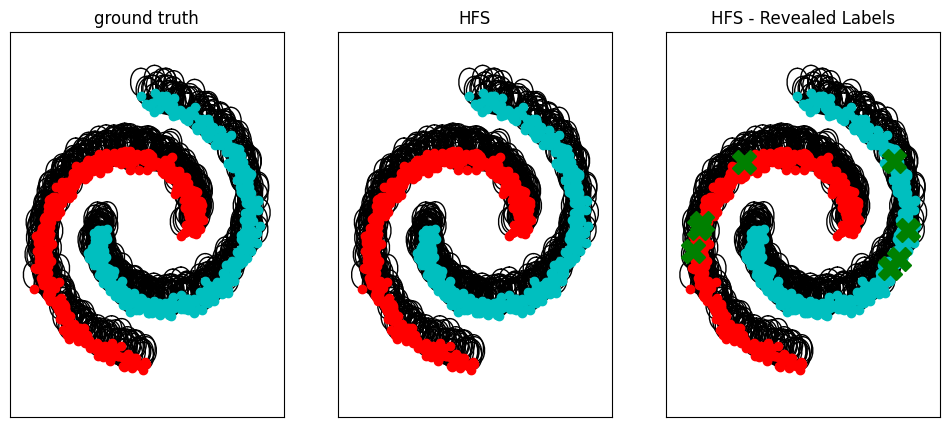

Number of trials: 20
Mean accuracy: 1.0


In [63]:
params['k'] = 30 
params['laplacian_normalization'] = 'unn'
accuracy = []

# Apply HFS to large two-moons dataset 20 times 
for ii in range(20):
    plot=True if ii==0 else False
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                      dataset='data_2moons_hfs_large.mat',
                                                      plot=plot, seed=None, PerClass=True, print_accuracy=False, **params)
    accuracy.append(hard_accuracy)

print('Number of trials:', str(len(accuracy)))
print('Mean accuracy:' ,np.mean(accuracy))

### Comments on 1.2 

As we select only four labeled samples along $1000$ for a two class problem by setting $l=4$, we obtain the four selected points of the same class in at least one of 20 iterations. Thus, that leads to the error "only one class in training data!". To fix this, I suggest to increase the number of selected points, so the probability of having different classes. To do so, I modified previous function two_moons_hfs and add it an argument PerClass which takes the same fixed number $l$ of labeled samples per class instead of $l$ in total. Therefore, that ensures to have all classes in selected labeled samples.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

- **dataset = data_2moons_hfs**

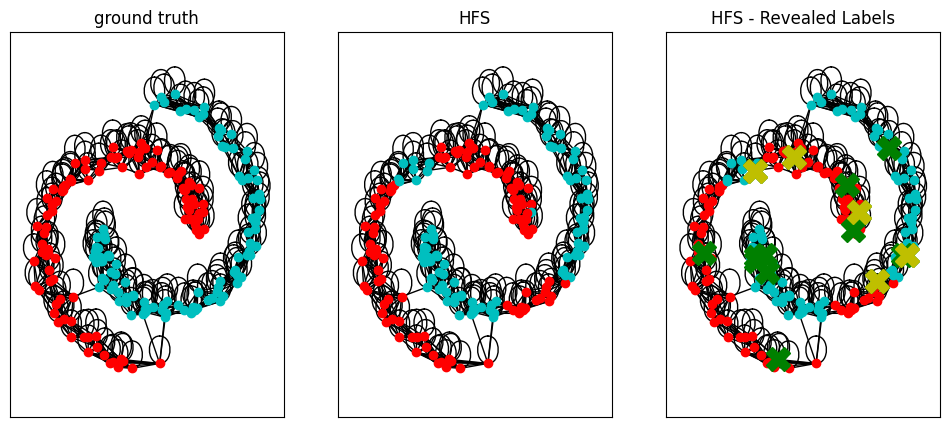

Soft=False, Accuracy=0.88


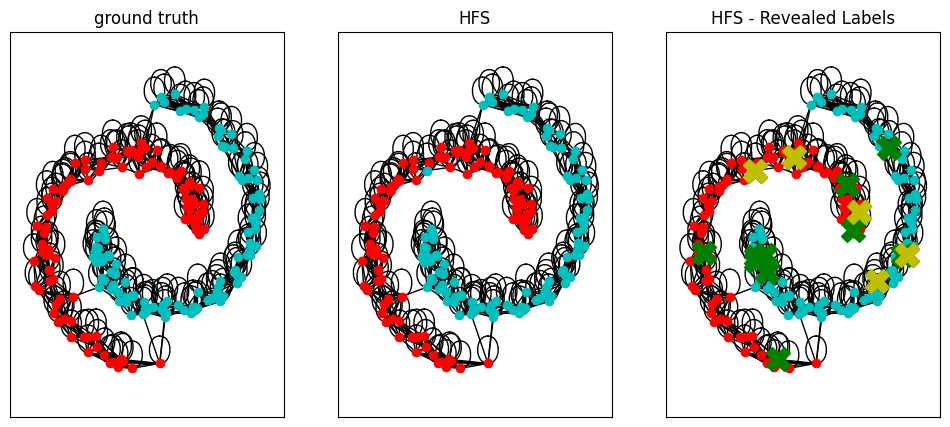

Soft=True, Accuracy=0.995
Experiment of 20 trials: 

- Hard HFS:
Mean accuracy: 0.837
- Soft HFS:
Mean accuracy: 0.88


In [64]:
seed = 2402  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

params['k']=10
params['laplacian_normalization']= 'unn'

#Plot the results after applying HFS one time

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, print_accuracy=True, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, print_accuracy=True, **params)

#Parameters
seed = None
plot = False
hard_accuracy_list = []
soft_accuracy_list = []

#loop for HPSs
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, print_accuracy= False, **params)

    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                     plot=plot, seed=seed, print_accuracy= False, **params)
    
    hard_accuracy_list.append(hard_accuracy)
    soft_accuracy_list.append(soft_accuracy)

# Report of experiment
print('Experiment of 20 trials: ')
print()
print('- Hard HFS:')
print('Mean accuracy:' ,round(np.mean(hard_accuracy_list), 3))
print('- Soft HFS:')
print('Mean accuracy:' ,round(np.mean(soft_accuracy_list), 3))

- **dataset = data_2moons_hfs_large**

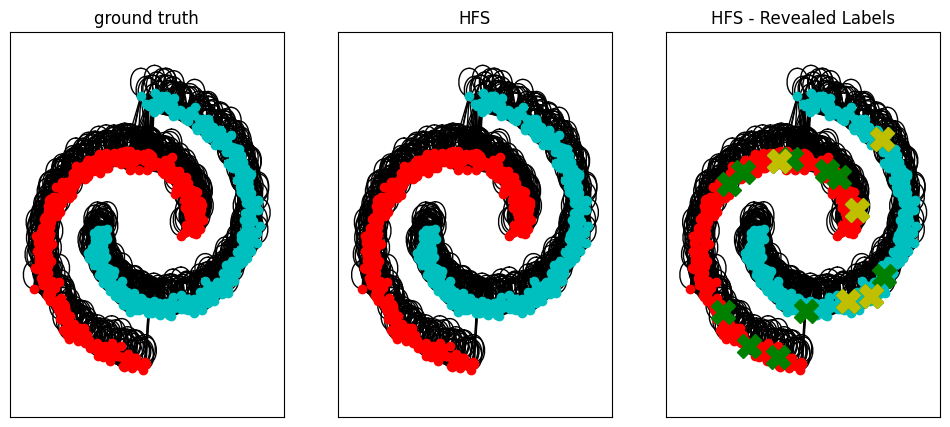

Soft=False, Accuracy=1.0


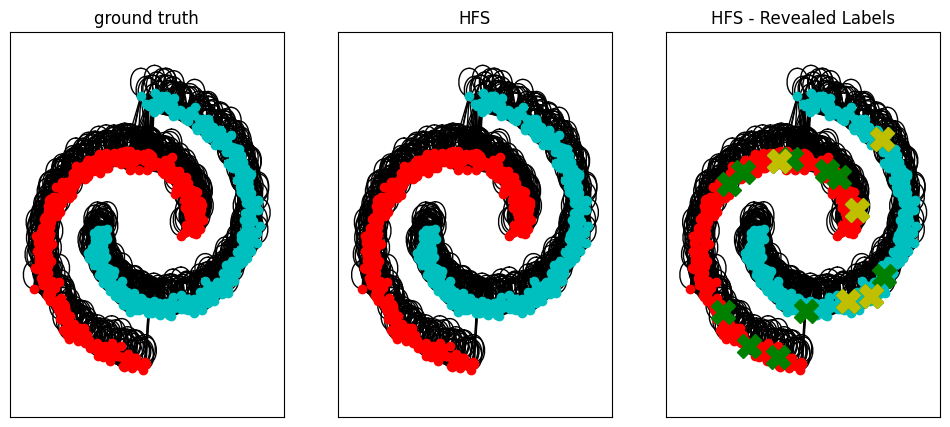

Soft=True, Accuracy=1.0
Experiment of 20 trials: 

- Hard HFS:
Mean accuracy: 0.928
- Soft HFS:
Mean accuracy: 0.932


In [65]:
seed = 2402  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs_large.mat'

params['k']=45
params['laplacian_normalization']= 'unn'

#Plot the results after applying HFS one time

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, print_accuracy=True, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, print_accuracy=True, **params)

#Parameters
seed = None
plot = False
hard_accuracy_list = []
soft_accuracy_list = []

#loop for HPSs
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, print_accuracy= False, **params)

    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                     plot=plot, seed=seed, print_accuracy= False, **params)
    
    hard_accuracy_list.append(hard_accuracy)
    soft_accuracy_list.append(soft_accuracy)

# Report of experiment
print('Experiment of 20 trials: ')
print()
print('- Hard HFS:')
print('Mean accuracy:' ,round(np.mean(hard_accuracy_list), 3))
print('- Soft HFS:')
print('Mean accuracy:' ,round(np.mean(soft_accuracy_list), 3))

**Comments:** 

Soft and Hard HFS were both utilized in this experiment with the two moons dataset. The Soft HFS method was observed to perform better than Hard HFS, despite the small difference in accuracy. Multiple experiments confirmed that Soft HFS is more accurate and stable compared to Hard HFS. The reason being that Hard HFS does not change the labels of the labeled points, hence, the noise from these points can propagate. Only the unlabeled points are labeled based on the noisy labels. Conversely, Soft HFS predicts the harmonic function of all points, including labeled points, which decreases the impact of noise. Therefore, it is recommended to use Soft HFS to prevent error propagation.

For larger datasets, Soft HFS remains the better option. It correctly labels all samples with high accuracy, whereas the accuracy of Hard HFS increases only due to the increase in the number of samples, compared to the error rate.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

**Answer:** 

To enable labeling of more than two classes, I utilized the OneHotEncoder to encode the labels. This encoding method represents each class value as a binary vector, where all values are zero except for the index of the class, which is marked with a 1 (like we did in the class Deep Learning in Practice). In the absence of a label for a sample, all columns are set to zero. Consequently, the harmonic function is now in $\mathbb{R}^{N \times C}$, where $C$ represents the number of classes and $N$ represents the number of samples. Moreover, the labels are assigned to the class with the highest score, which is determined by the #next index of the class.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

    
**Answer:**

Data preprocessing was the first step in this inquiry. We experimented with various image enhancement techniques, starting with applying a bilateral filter to the image. We then used the CLAHE (Contrast Limited Adaptive Histogram Equalization) method, which is more effective than the standard histogram equalization method. CLAHE can handle variations in facial expressions, occlusions, and particularly illumination changes. It is an improved version of histogram equalization that overcomes the limitations of the standard method when dealing with localized gray level distributions and low-contrast images. Finally, we applied a median filter with a size of $3$ to the resulting image, which is superior to Gaussian blur in preserving edges while removing noise.


`load_image_data_augmented` returned error :(

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

In [8]:
import os
import cv2
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [9]:
"""
Define parameters for face recognition with HFS

"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 5000.0
params_face_rec['eps'] = None
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 0.95
params_face_rec['c_u'] = 0.05

In [10]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

- **First dataset: 10 images per person**

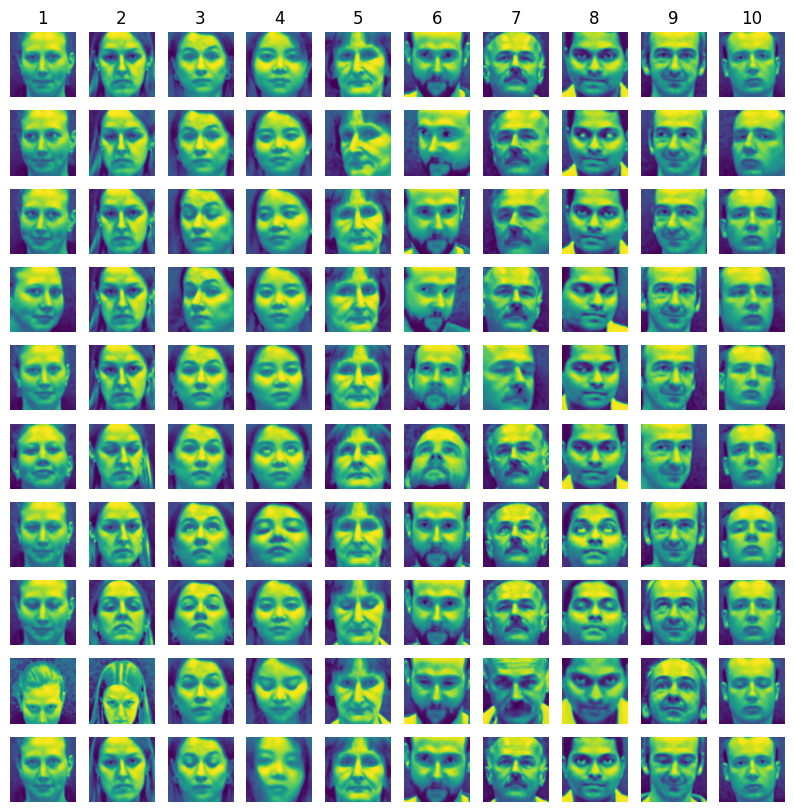

In [79]:
# 10 images per person
np.random.seed(456)  
images, labels, masked_labels = load_image_data(preprocess_image)
plot_image_data(images)

In [11]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

NameError: name 'images' is not defined

In [12]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

NameError: name 'L' is not defined

In [72]:
# # 50 images per person
# images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
# plot_image_data_augmented(images_a)

Somehow, the function load_image_data_augmented() doesn't work.


## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

**Answer:** 

For the training phase, we utilized 10 images featuring "Zeki Topcu" and 10 images of "Messi" face. Following this, we implemented the online SSL algorithm and after parameter adjustments, we discovered that optimal results were attained with the following settings: $k=15$, Laplacian $L_{unn}$, Laplacian regularization set to 0.05, $c_l=0.9$, and $c_u=0.1$.

### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [14]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = None
params_online_ssl['c_u'] = None

In [15]:
class IncrementalKCenters:
    
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """
        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            
            """                     
            nbr = self.centroids_distances.shape[0]
            idx_list = np.argsort(self.centroids_distances.ravel())
            for idx in idx_list:
                c_1 = idx // nbr
                c_2 = idx % nbr
                if (c_1 not in self.taboo) or (c_2 not in self.taboo):
                    break                  
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_rep = c_2
                c_add = c_1
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1               

            """
            Update data structures: self.centroids and self.V
            
            """
            self.V[c_rep] += self.V[c_add]
            self.centroids[c_add,:] = face
            self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            
            """
            dist_row =distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add,:] =dist_row
            self.centroids_distances[:,c_add] =dist_row
            self.last_face =c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.
        Returns a prediction corresponding to self.last_face.
        
        """
        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
        # Build quantized graph and its regularized Laplacian
        W_tilde = build_similarity_graph(self.centroids, var=params_online_ssl['var'], 
                                       k=params_online_ssl['k'], 
                                       eps=params_online_ssl['eps'])
        W = V @ W_tilde @ V 
        L = build_laplacian(W, params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization']*np.eye(L.shape[0]) 

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)
    
        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            # handle unknown faces
            if np.max(f[self.last_face]) < 0.85 :
                label = "unknown"
            label_scores.append((label, score))
        
        return label_scores

In [19]:
# Construct datasets
#create_user_profile('Zeki')        
#create_user_profile('Deniz')

# Choose parameters 
params_online_ssl['k'] = 15
params_online_ssl['laplacian_regularization'] = 0.05

# Perform Online face recognition   
online_face_recognition(['Zeki Topcu'], IncrementalKCenters, n_pictures=10)


Profile found with 10 images.


## Result ##

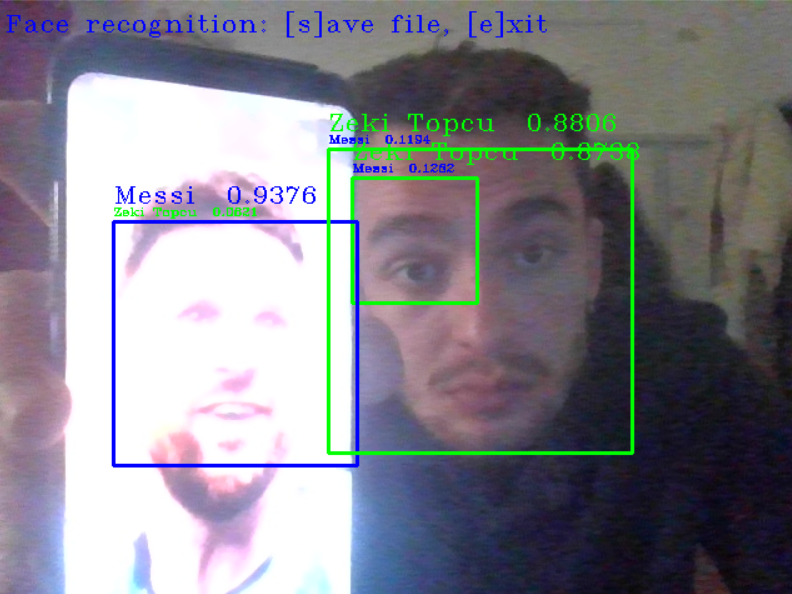

In [77]:
from IPython.display import Image
Image(filename='data/results_messi_zeki.png') 